## Load and Preprocess Image Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random

Let's quickly write down our class indices for consistency throughout the program!

In [ ]:
classes = ["basophil", "eosinophil", "neutrophil"]
class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}

In [ ]:

file_path = "/content/drive/MyDrive/bloodcells_dataset/"     # make sure it ends with bloodcells_dataset/ so we can access the different subfolders
baso = [f for f in listdir(file_path + "basophil") if isfile(join(file_path + "basophil", f)) and f != ".DS_Store"]
eosi = [f for f in listdir(file_path + "eosinophil") if isfile(join(file_path + "eosinophil", f)) and f != ".DS_Store"]
neutro = [f for f in listdir(file_path + "neutrophil") if isfile(join(file_path + "neutrophil", f)) and f != ".DS_Store"]
data = baso + eosi + neutro
random.shuffle(data)

In [ ]:
class BloodCell_Dataset(Dataset):
    def __init__(self, file_path, file_path_list, mode="train", test_size=0.2):
        self.file_path = file_path
        self.classes = ["basophil", "eosinophil", "neutrophil"]
        self.class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
        self.idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}
        self.data = file_path_list
        assert mode in ['train', 'test'], f'mode needs to be either train or test, but it\'s {mode}'
        partition = int(len(self.data) * (1 - test_size))
        if mode == 'train':
            self.data = self.data[:partition]
        else:
            self.data = self.data[partition:]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)                                # if we're creating the test set, we can just fetch all images
                if len(img.shape) == 3:                                         # at once because the test set size is usually much smaller
                    img = img.unsqueeze(0)                                      # of course this may not ALWAYS be the case...
                self.tensor_imgs.append(img)
                self.labels.append(label.item())

            self.tensor_imgs = torch.cat(self.tensor_imgs, dim=0).type(torch.float32)
            self.labels = torch.tensor(self.labels).type(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        file_name = self.data[i]

        if "SNE" in file_name or "NEU" in file_name or "BNE" in file_name:      # each file name tells us whether the image is class 0, 1, or 2
            label = 2                                                           # so that's how we keep track of our labels
        elif "EO" in file_name:
            label = 1
        elif "BA" in file_name:
            label = 0

        convert_tensor = transforms.ToTensor()
        path = self.file_path + self.idx2class[label] + "/" + file_name
        img = Image.open(path)
        tensor_img = convert_tensor(img)                                        # converts image to 3D torch.Tensor
        if tensor_img.shape != (3, 363, 360):
            tensor_img = tensor_img[:, 3:366, 3:363]                            # quick crop and reshape if the image is not uniform
        return tensor_img.type(torch.float32), torch.tensor(label).type(torch.long)

    def get_test(self):
        return self.tensor_imgs, self.labels

In [ ]:
training_data = BloodCell_Dataset(file_path, data, mode='train')
testing_data = BloodCell_Dataset(file_path, data, mode='test')

In [ ]:
print(f"Size of training_data:\t{len(training_data)}")
print(f"Size of testing_data:\t{len(testing_data)}")

Size of training_data:	390
Size of testing_data:	98


In [ ]:
test, test_label = testing_data.get_test()
print(test.shape)
print(test_label.shape)

torch.Size([98, 3, 363, 360])
torch.Size([98])


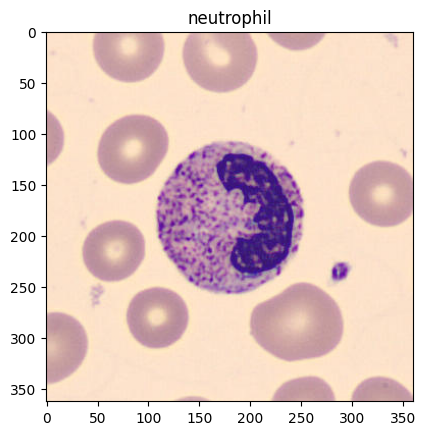

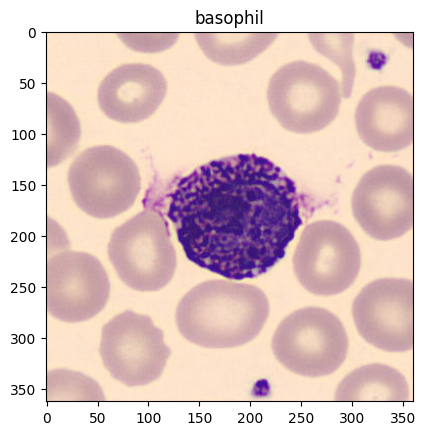

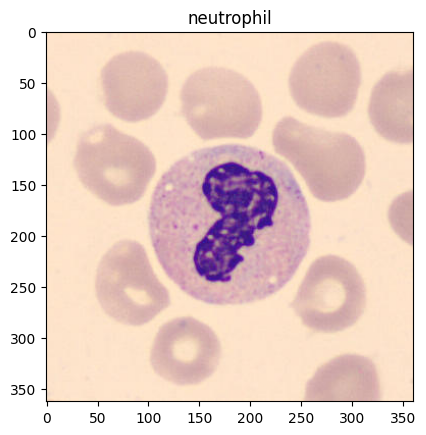

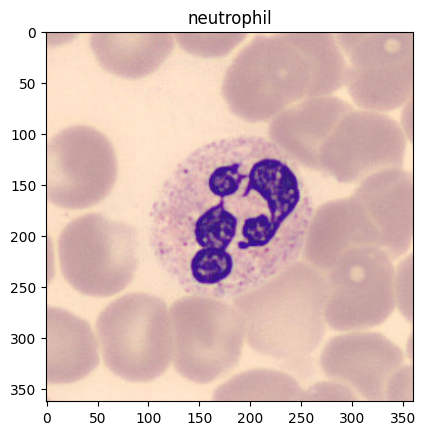

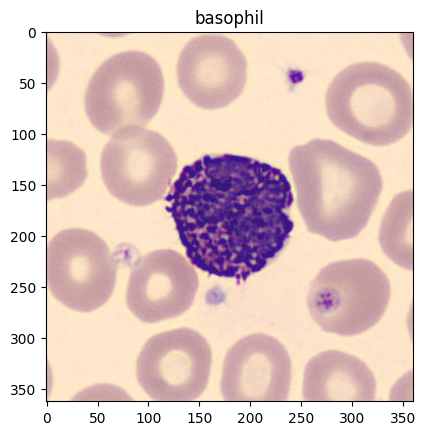

In [ ]:
def graph_cell(img, label, memo=""):
    """
    img: a torch.Tensor or a np.ndarray
    label: an integer
    """
    if type(img) == torch.Tensor:
        img = img.detach().cpu().numpy().squeeze()
    img = np.transpose(img.squeeze(), (1, 2, 0))
    plt.imshow(img)
    plt.title((idx2class[label]) + memo)
    plt.show()

for i in range(5):
    img, label = training_data[i]
    graph_cell(img, label.item())

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
print("Using device:", device)

Using device: cpu


In [ ]:
class BloodCell_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### YOUR CODE HERE

        """
        Define your layers here.
        """
        self.conv1 = nn.Conv2d(3, 64, kernel_size=2, padding=1, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2, padding=1, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, padding=1, stride=1)

        self.bn1 = nn.BatchNorm2d(64)#nn.GroupNorm(num_groups=8, num_channels=64)
        self.bn2 = nn.BatchNorm2d(64)#nn.GroupNorm(num_groups=8, num_channels=64)
        self.bn3 = nn.BatchNorm2d(64)#nn.GroupNorm(num_groups=8, num_channels=64)

        self.max_pool = nn.MaxPool2d(2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()

        self.classifier = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X):

        """
        Design the process of your network.
        """

        if len(X.shape) == 3:            # if one single image is passed, make sure it's of dimension (1, 3, H, W)
          X = X.unsqueeze(0)

        #resizing input vector as I begin to normalize
        X = F.interpolate(X, size=(128, 128), mode="bilinear", align_corners=False)

        # Scale to [0, 1] if not already
        if X.max() > 1.0:
          X = X / 255.0

        #channel-wise mean and standard deviation of RGB pixel values, common in computer vision
        mean = torch.tensor([0.485, 0.456, 0.406], device=X.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=X.device).view(1, 3, 1, 1)

        #normalize
        X = (X - mean) / std

        #begin layers
        X = self.relu1(self.bn1(self.conv1(X)))
        X = self.max_pool(X)
        X = self.relu2(self.bn2(self.conv2(X)))
        X = self.max_pool(X)
        X = self.relu3(self.bn3(self.conv3(X)))
        X = self.global_avg_pool(X)
        X = torch.flatten(X, 1)
        X = self.dropout(X)

        #extract logits from data
        logits = self.classifier(X)

        return logits   # do not apply softmax

    def classify(self, X):

        """
        Write a function that outputs the labels.
        """
        #check data type
        if not isinstance(X, torch.Tensor):
          X = torch.tensor(X, dtype=torch.float32)

        #using the weights from the device that made the model, getting the first item from the iterator
        X = X.to(next(self.parameters()).device)

        #making sure that classification is done with eval mode, developing accurate inference
        self.eval()

        #collecting logits from the forward algorithm
        logits = self.forward(X)

        #softmax applied to logits
        probs = F.softmax(logits, dim=1)

        return torch.argmax(probs, dim=1)



In [ ]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train(model, training_data, testing_data, epochs=15, batch_size=16, lr=1e-3):
    """
    Q:  write the training loop following the schema shown above.

    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - X_train, y_train, X_val, y_val: training and validation data
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate
    - optimizer: optimizer used

    Outputs
    - losses: a list of losses
    - accuracies: a list of accuracies
    """

    ### YOUR CODE HERE
    #empty the gpu cache
    torch.cuda.empty_cache()
    #access the model, move weights to device
    model = model.to(device)

    #data management
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

    #setting values for current best accuracy and model
    best_acc = -1
    best_model = None

    #declaration of cross entropy loss function and adam optimizer with lr
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #lists to compile losses and accuracy scores for all epochs
    losses, accuracies = [], []

    #epoch loop begins
    for epoch in range(epochs):
      #put the model in training mode
      model.train()
      epoch_loss = 0

      #training loop iterates through images with true labels
      for imgs, labels in train_dataloader:
          #saving both to device, and assigning both to variables
          x_batch = imgs.to(device)
          y_batch = labels.to(device)

          #using the optimizer
          optimizer.zero_grad()
          #getting training logits
          logits = model(x_batch)
          #calculate loss
          loss = loss_fn(logits, y_batch)
          #back propagate loss
          loss.backward()
          #step adam optimizer forward
          optimizer.step()

          #record loss as sum per epoch
          epoch_loss += loss.item()

      #calculate the average loss for all epochs
      avg_loss = epoch_loss / len(train_dataloader)
      losses.append(avg_loss)

      #switch model to eval mode
      model.eval()

      #lists to store prediction and label outcomes to later calculate accuracy score
      all_preds, all_labels = [], []

      #does track gradients within this block, used for model eval
      with torch.no_grad():
        #similar to training loop
        for imgs, labels in test_dataloader:
          x_batch = imgs.to(device)
          y_batch = labels.to(device)

          logits = model(x_batch)
          preds = torch.argmax(logits, dim=1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(y_batch.cpu().numpy())
      #calculate accuracy scores from the eval lists, append for return vector
      accuracy = accuracy_score(all_labels, all_preds)
      accuracies.append(accuracy)

      #check if the current model accuracy is the best yet
      if accuracy > best_acc:
          best_acc = accuracy
          #if so, save the model
          best_model = deepcopy(model.state_dict())

        # print epoch, loss, and current test accuracy (don't delete this line - it's slightly more organized now)
      print(f"Epoch {epoch + 1}:\tloss {np.round(avg_loss, 4)}\t& accuracy {np.round(accuracy, 4)}")
    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")

    #making sure that the best model is loaded and assigned to the model object
    model.load_state_dict(best_model)
    #torch.save(model.state_dict(),  file_path + "my_model.pt")

    return losses, accuracies

In [ ]:
model = BloodCell_CNN()
losses, accuracies = train(model, training_data, testing_data, batch_size=16, epochs=10)

Epoch 1:	loss 0.9836	& accuracy 0.5204
Epoch 2:	loss 0.7867	& accuracy 0.8163
Epoch 3:	loss 0.6717	& accuracy 0.8469
Epoch 4:	loss 0.572	& accuracy 0.8367
Epoch 5:	loss 0.4739	& accuracy 0.7143
Epoch 6:	loss 0.4099	& accuracy 0.949
Epoch 7:	loss 0.3131	& accuracy 0.9184
Epoch 8:	loss 0.2937	& accuracy 0.9184
Epoch 9:	loss 0.2598	& accuracy 0.898
Epoch 10:	loss 0.2227	& accuracy 0.9592
Resetting model... Best validation accuracy:	0.9592


In [ ]:
torch.cuda.empty_cache()
imgs = testing_data.tensor_imgs[:10]
labels = testing_data.labels[:10]
preds = model.classify(imgs.to(device))
for i in range(10):
    graph_cell(imgs[i], preds[i].item(), memo=f"  (target: {idx2class[labels[i].numpy().item()]})")

In [ ]:
#model.load_state_dict(best_model)
torch.save(model.state_dict(), file_path + "my_model.pt")       # save your model - do NOT change the name of
                                                                   # the model or else the autograder won't recognize it!

In [ ]:
# empty some RAM
torch.cuda.empty_cache()
del testing_data
del training_data

test_path = "/content/drive/MyDrive/bloodcells_dataset/test_data.npy"

test = np.load(test_path)
test = torch.tensor(test).type(torch.float32).to(device)
test = test.permute(0, 3, 1, 2)

# split the hidden test data in half to avoid GPU memory problems
preds1 = model.classify(test[:71])
preds1 = preds1.detach().cpu().numpy()

torch.cuda.empty_cache()
preds2 = model.classify(test[71:])
preds2 = preds2.detach().cpu().numpy()

preds = np.concatenate([preds1.flatten(), preds2.flatten()])

np.save("/content/drive/MyDrive/bloodcells_dataset/predictions.npy", preds)
print("Predictions saved!")

Predictions saved!
